In [1]:
options(repr.plot.width=6.5, repr.plot.height=5, jupyter.plot_mimetypes='image/svg+xml')
source('common.r')
out <- function(obj) write(obj, stdout())

In [ ]:
sessionInfo()

# Raw Mix

In [22]:
d <- data.ipa.rawmix(where="datatype='counter' and ipa_duration=60 and ipa_version='v1.6'")
out("data:   " + nrow(d))

d$grp <- d$ipa_bound
d$facet <- factor(d$honeycomb_mode)
d$x <- d$load

d$inconsistent <- d$counters_inconsistent_count
d$consistent <- d$counters_consistent_count
d$inconsistent_fraction <- d$inconsistent / (d$inconsistent + d$consistent)

s <- subset(d, grepl('normal|slowpoke_flat', honeycomb_mode) & mix == 'no_size' & grepl('\\{.*\\}', containers))
out("subset: " + nrow(s))

The following `from` values were not present in `x`: world


data:   109
subset: 109


In [4]:
sql("SELECT load, ipa_bound, honeycomb_mode, timers_read_latency_mean as mean_lat FROM s")

,load,ipa_bound,honeycomb_mode,mean_lat
1,16,tolerance:0.1,normal,25.48478
2,16,tolerance:0.1,slowpoke_flat,77.67934
3,128,tolerance:0.1,normal,28.55727
4,128,tolerance:0.1,slowpoke_flat,90.68688
5,512,tolerance:0.1,normal,29.47971
6,512,tolerance:0.1,slowpoke_flat,88.84698
7,2048,tolerance:0.1,normal,29.47911
8,2048,tolerance:0.1,slowpoke_flat,82.65839
9,4096,tolerance:0.1,normal,28.96816
10,4096,tolerance:0.1,slowpoke_flat,84.12129


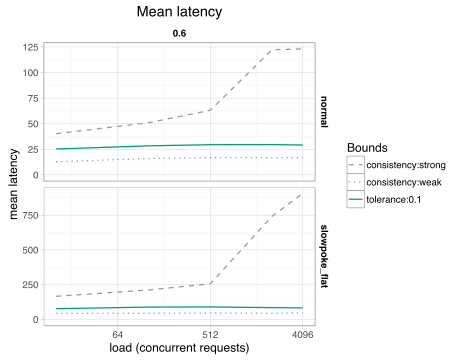

In [29]:
source('common.r')
ggplot(subset(s, x <= 4096), aes(
    x=x, y=timers_read_latency_mean, color=grp, fill=grp, linetype=grp, group=grp
))+
    stat_summary(geom='line', fun.y=mean, size=0.6)+
    ggtitle('Mean latency')+
    xlab('load (concurrent requests)')+
    ylab('mean latency')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~ipa_zipf, scales="free")+
    theme_mine()+
    ipa.scales()

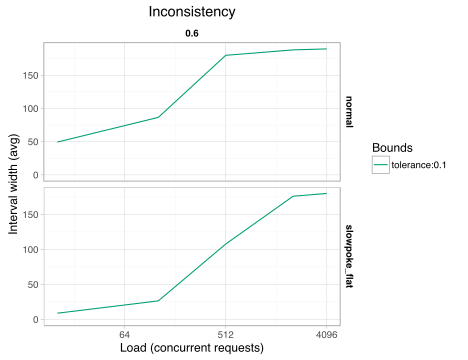

In [33]:
ggplot(subset(s, ipa_bound == 'tolerance:0.1'), aes(
    x = x, y= histograms_interval_width_mean, color=grp, fill=grp, group=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle('Inconsistency')+
    xlab('Load (concurrent requests)')+
    ylab('Interval width (avg)')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~ipa_zipf, scales="free")+
    ipa.scales()+
    theme_mine()

In [ ]:
ggplot(subset(s, x <= 4096), aes(
    x=x, y=rate_contains, color=grp, fill=grp, group=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle('Mean throughput')+
    group.legend(title='Bounds')+
    xlab('load (concurrent requests)')+
    ylab('mean throughput')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~containers, scales="free")+
    my_theme()

In [ ]:
ggplot(melt.by(subset(s, x <= 4096), 'op', 'mean_lat_(contains|size)'), aes(
    x=x, y=value, color=grp, fill=grp, group=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle('Mean latency')+
    group.legend(title='Bounds')+
    xlab('load (concurrent requests)')+
    ylab('mean latency')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~op, scales="free")+
    my_theme()

In [ ]:
ggplot(melt.by(s, 'op', 'timers_(contains|size)_latency_p95'), aes(
    x=x, y=value, color=grp, fill=grp, group=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle('95th Percentile Latency')+
    group.legend(title='Bounds')+
    xlab('Load (concurrent requests)')+
    ylab('95th percentile latency (ms)')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~op)+
    my_theme()

In [ ]:
ggplot(s, aes(x=x, y=value, color=grp, fill=grp, group=grp))+
    stat_summary(geom='line', fun.y=mean)+
    scale_x_continuous(trans=log2_trans())+
    facet_wrap(~honeycomb_mode)+
    my_theme()

In [ ]:
read_ops <- c('contains', 'size')
levels <- c('strong', 'weak')

In [ ]:
for(op in read_ops) s['counters_'+op+'_weak_ratio'] <- s['counters_'+op+'_weak_count'] / (s['counters_'+op+'_strong_count']+s['counters_'+op+'_weak_count'])

m <- melt(s, measure=p('counters_'+read_ops+'_weak_ratio'))

m$op <- capply(m$variable, function(s) gsub('counters_(\\w+)_weak_ratio', '\\1', s))
m$fraction_weak <- m$value

ggplot(m, aes(x=x, y=fraction_weak, color=grp, fill=grp, group=grp))+
    stat_summary(geom='line', fun.y=mean)+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~op)+
    ggtitle('Fraction executed with weak consistency')+
    group.legend(title='Bounds')+
    xlab('Load (concurrent requests)')+
    ylab('Fraction of weakly consistent actions')+
    my_theme()

In [ ]:
tmp <- ddply(m, .(honeycomb_mode, ipa_bound, op, level, x), summarize, count=mean(count))
sql("SELECT * FROM tmp WHERE ipa_bound like 'latency%' ORDER BY honeycomb_mode, ipa_bound, op, x")

In [ ]:
m$grp <- m$level
ggplot(m, aes(x=x, y=count, color=grp, fill=grp, group=grp))+
    stat_summary(geom='line', fun.y=mean)+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~op~ipa_bound)+
    my_theme()

# Retwis

In [ ]:
d <- data.or.csv(
    csv = 'data/owl.csv',
    gen = function() data.owl()
)

In [ ]:
subset(d, duration == 60 & blockade == 'slow', select=c('c_reqs','ipa_consistency','op_rate'))

In [ ]:
d$x <- d$c_reqs
d$grp <- d$ipa_consistency
s <- subset(d, duration == 60 & blockade == 'slow' & !is.na(ipa_consistency))

ggplot(s, aes(x=x, y=op_rate, color=grp, fill=grp, group=grp))+
    stat_summary(geom='line', fun.y=mean)+
    xlab('system load (# concurrent requests)')+
    ylab('mean cassandra op latency (ms)')+
    my_theme()

In [ ]:
ggplot(s, aes(x=x, y=op_lat_mean, color=grp, fill=grp, group=grp))+
    stat_summary(geom='line', fun.y=mean)+
    xlab('system load (# concurrent requests)')+
    ylab('mean cassandra op latency (ms)')+
    my_theme()